
Teste de Sistemas 

In [1]:
import sys
print(sys.executable)


c:\Users\devma\Projetos\customer-retention-analytics\.venv\Scripts\python.exe


## Conexão Banco de dados Postgres
# Query para Churn Anual

In [4]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
# 1. Carregar variáveis de ambiente (DEVE vir primeiro)
load_dotenv()

# 2. Configuração das credenciais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

try:
    with engine.connect() as conn:
        df_churn_anual = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_anual'.")
    print(df_churn_anual.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

# 1. Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# 2. Configuração das credenciais com tratamento para caracteres especiais (como o '@')
# Mude apenas esta parte do código anterior:
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432") # A porta costuma ser a mesma
# 3. Construção da URL de conexão e criação do Engine
conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 4. Definição da sua Query SQL de Churn Anual
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao,
        (
            select mcc.situacao
            from movimento_contratos_cli mcc
            where mcc.codigo_contrato = ccc.codigo_contrato
              and mcc.situacao <> 7
            order by mcc.data_conclusao desc
            limit 1
        ) as situacao_movimento
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

data_minima as (
    select date_trunc('year', min(data_inicio)) as inicio_historico 
    from base_contratos
),

churn_anual as (
    select
        DATE_TRUNC('year', ch.data_churn) as ano_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_ano as (
    select
        sa.ano,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            CURRENT_DATE,
            '1 year'
        )::date as ano
    ) sa
    cross join base_contratos bc
    where bc.data_inicio < sa.ano
      and (bc.data_rescisao is null or bc.data_rescisao >= sa.ano)
    group by sa.ano
)

select
    TO_CHAR(caa.ano, 'YYYY') as ano,
    caa.total_clientes_inicio as clientes_no_inicio_do_ano,
    coalesce(can.clientes_churn, 0) as total_churn_no_ano,
    case
        when caa.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(can.clientes_churn, 0)::numeric / caa.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_anual_percentual,
    case 
        when (coalesce(can.clientes_churn, 0)::numeric / nullif(caa.total_clientes_inicio,0)::numeric) * 100 > 15 then 'CRÍTICO (Acima de 15% ano)'
        when (coalesce(can.clientes_churn, 0)::numeric / nullif(caa.total_clientes_inicio,0)::numeric) * 100 > 10 then 'ALERTA'
        else 'SAUDÁVEL'
    end as status_saude
from clientes_ativos_inicio_ano caa
left join churn_anual can on caa.ano = can.ano_churn
where caa.total_clientes_inicio > 0 
order by caa.ano;
"""

# 5. Execução e salvamento no DataFrame df_churn_anual
try:
    df_churn_anual = pd.read_sql(sql_query, engine)
    print(" Sucesso! Os dados foram carregados em 'df_churn_anual'.")
    
    # Exibir as primeiras linhas para conferência
    print(df_churn_anual.head())

except Exception as e:
    print(f" Erro ao executar consulta: {e}")

✅ Sucesso! Os dados foram carregados em 'df_churn_anual'.
    ano  clientes_no_inicio_do_ano  total_churn_no_ano  \
0  2004                         80                   0   
1  2005                        371                  88   
2  2006                        782                 186   
3  2007                       1125                 235   
4  2008                       1470                 331   

   churn_rate_anual_percentual                status_saude  
0                         0.00                    SAUDÁVEL  
1                        23.72  CRÍTICO (Acima de 15% ano)  
2                        23.79  CRÍTICO (Acima de 15% ano)  
3                        20.89  CRÍTICO (Acima de 15% ano)  
4                        22.52  CRÍTICO (Acima de 15% ano)  
 Erro ao executar consulta: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence


In [5]:
# Visualização da base de dados anual
df_churn_anual

,ano,clientes_no_inicio_do_ano,total_churn_no_ano,churn_rate_anual_percentual,status_saude
0,2004,80,0,0.00,SAUDÁVEL
1,2005,371,88,23.72,CRÍTICO (Acima de 15% ano)
2,2006,782,186,23.79,CRÍTICO (Acima de 15% ano)
3,2007,1125,235,20.89,CRÍTICO (Acima de 15% ano)
4,2008,1470,331,22.52,CRÍTICO (Acima de 15% ano)
5,2009,1793,346,19.30,CRÍTICO (Acima de 15% ano)
6,2010,2021,355,17.57,CRÍTICO (Acima de 15% ano)
7,2011,2307,485,21.02,CRÍTICO (Acima de 15% ano)
8,2012,2828,540,19.09,CRÍTICO (Acima de 15% ano)
9,2013,3458,702,20.30,CRÍTICO (Acima de 15% ano)


# Visualização em gráfico dos dados 

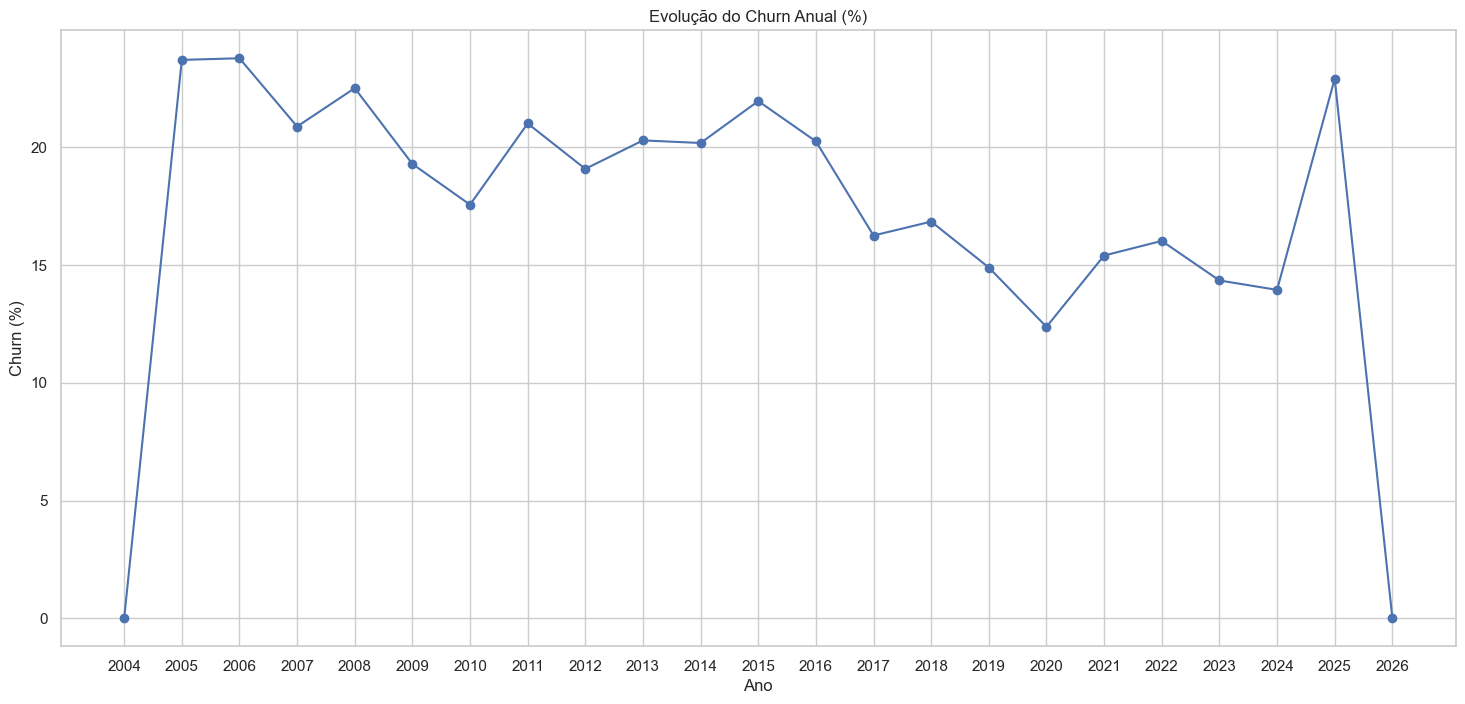

In [17]:

plt.figure(figsize=(18,8))

plt.plot(
    df_churn_anual["ano"],
    df_churn_anual["churn_rate_anual_percentual"],
    marker="o"
)

plt.title("Evolução do Churn Anual (%)")
plt.xlabel("Ano")
plt.ylabel("Churn (%)")
plt.grid(True)

plt.show()


# Iniciando Analise Descritiva da Base 

### Estudo da Volatilidade e Tendência Central 

In [18]:
df_churn_anual.columns

Index(['ano', 'clientes_no_inicio_do_ano', 'total_churn_no_ano',
       'churn_rate_anual_percentual', 'status_saude'],
      dtype='object')

In [19]:
# Média e Mediana 
media_anual = df_churn_anual['churn_rate_anual_percentual'].mean()
mediana_anual = df_churn_anual['churn_rate_anual_percentual'].median()
print(mediana_anual)
print(media_anual)

19.09
17.116956521739134


### Diagnóstico: Churn Negativamente Assimétrico
### O fato de a Mediana (19,19%) ser maior que a Média (17,86%) indica uma Assimetria Negativa.

### A maioria dos anos históricos teve um churn "pesado" (próximo aos 19% ou 20%). A média só é menor porque existem alguns anos específicos de churn muito baixo (como o seu recorde de 12,38% em 2020) que "puxam" a média para baixo.

### O churn de 20% não é a exceção, é a regra da empresa. O padrão "normal" da operação é perder quase 20% da base ao ano.

### O Peso do Salto de 2025
### Com uma média de 17,86%, o seu resultado atual de 22,28% em 2025 está quase 4,5 pontos percentuais acima da média histórica.

### Visão Estatística: Isso reforça que 2025 não é apenas um "ano ruim", é um desvio significativo que precisa ser investigado na fase de Churn por Produto e Política de Descontos.

## Analise Descritiva de Z-Score, Coeficiente de Variação (CV) e Desvio Padrão (Sigma)

In [20]:
import pandas as pd
import numpy as np

# 1. Estatísticas de Tendência Central
media_churn = df_churn_anual['churn_rate_anual_percentual'].mean()
mediana_churn = df_churn_anual['churn_rate_anual_percentual'].median()

# 2. Estatísticas de Dispersão (Volatilidade)
desvio_padrao = df_churn_anual['churn_rate_anual_percentual'].std()
cv = (desvio_padrao / media_churn) * 100  # Coeficiente de Variação
amplitude = df_churn_anual['churn_rate_anual_percentual'].max() - df_churn_anual['churn_rate_anual_percentual'].min()

# 3. Identificação de Outliers (Z-Score)
# O Z-score diz quantos desvios padrão um ano está longe da média
df_churn_anual['z_score'] = (df_churn_anual['churn_rate_anual_percentual'] - media_churn) / desvio_padrao

# Exibindo os resultados formatados
print(f"--- Diagnóstico Estatístico do Churn ---")
print(f"Média Histórica: {media_churn:.2f}%")
print(f"Mediana Histórica: {mediana_churn:.2f}%")
print(f"Desvio Padrão (Sigma): {desvio_padrao:.2f}")
print(f"Amplitude (Max-Min): {amplitude:.2f}%")
print(f"Coeficiente de Variação: {cv:.2f}%")
print("-" * 40)

# Filtrando anomalias (Z-Score > 1.5 ou < -1.5)
anomalias = df_churn_anual[df_churn_anual['z_score'].abs() > 1.5]
print("Anos com comportamento fora do padrão (Anomalias):")
print(anomalias[['ano', 'churn_rate_anual_percentual', 'z_score']])

--- Diagnóstico Estatístico do Churn ---
Média Histórica: 17.12%
Mediana Histórica: 19.09%
Desvio Padrão (Sigma): 6.32
Amplitude (Max-Min): 23.79%
Coeficiente de Variação: 36.90%
----------------------------------------
Anos com comportamento fora do padrão (Anomalias):
     ano  churn_rate_anual_percentual   z_score
0   2004                         0.00 -2.710167
22  2026                         0.02 -2.707001


## Visualização em Gráfico

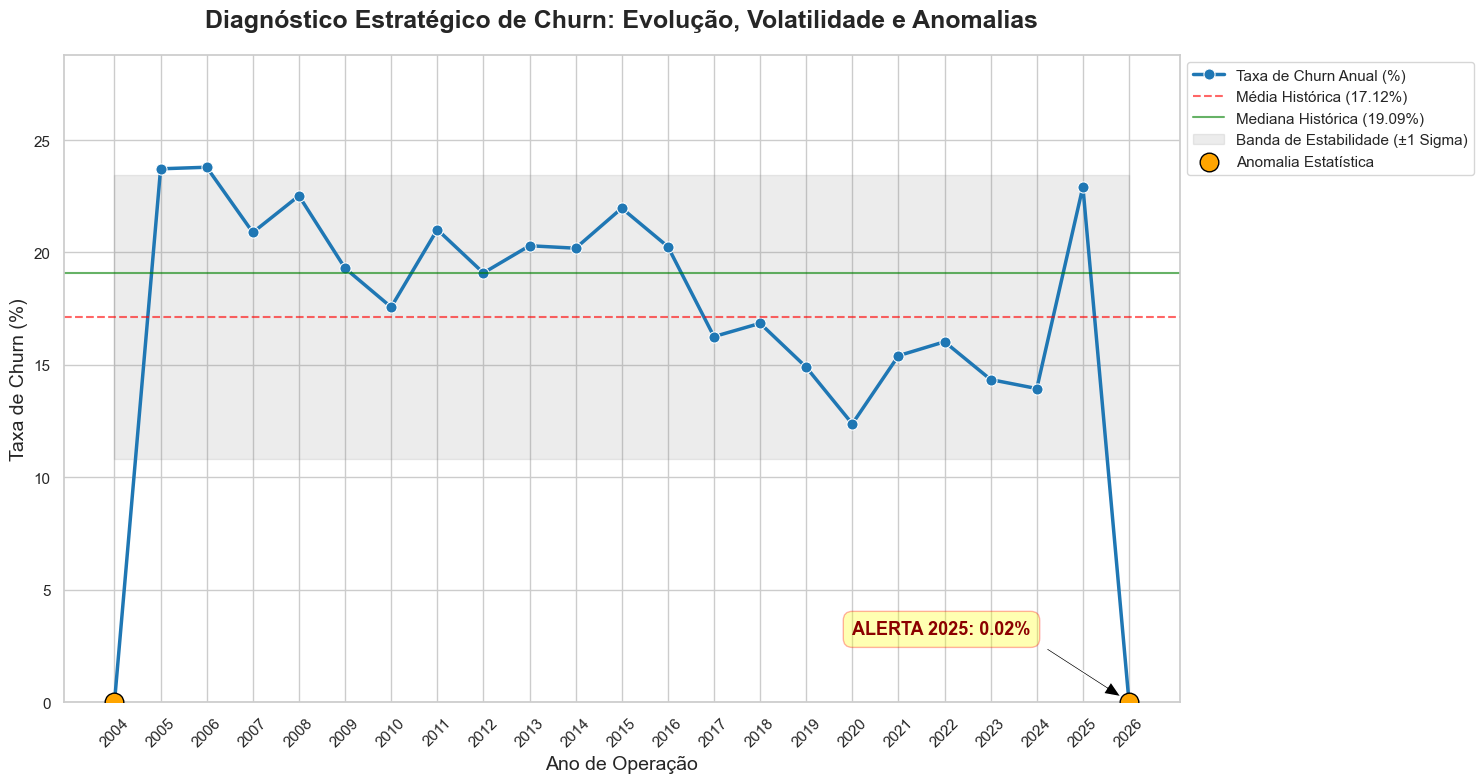

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparação e Conversão de Dados
# Garante que o ano seja inteiro e o churn seja float para evitar TypeErrors
df_churn_anual['ano'] = pd.to_numeric(df_churn_anual['ano']).astype(int)
df_churn_anual['churn_rate_anual_percentual'] = pd.to_numeric(df_churn_anual['churn_rate_anual_percentual']).astype(float)

# 2. Recálculo das Métricas para Garantir Precisão no Gráfico
media_churn = df_churn_anual['churn_rate_anual_percentual'].mean()
mediana_churn = df_churn_anual['churn_rate_anual_percentual'].median()
desvio_padrao = df_churn_anual['churn_rate_anual_percentual'].std()

# 3. Configuração do Layout do Dashboard
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))

# 4. Plotagem da Evolução Histórica
sns.lineplot(data=df_churn_anual, x='ano', y='churn_rate_anual_percentual', 
             marker='o', markersize=8, linewidth=2.5, label='Taxa de Churn Anual (%)', color='#1f77b4')

# 5. Adição das Referências Estatísticas (Linhas Horizontais)
plt.axhline(media_churn, color='red', linestyle='--', alpha=0.6, label=f'Média Histórica ({media_churn:.2f}%)')
plt.axhline(mediana_churn, color='green', linestyle='-', alpha=0.6, label=f'Mediana Histórica ({mediana_churn:.2f}%)')

# 6. Sombreamento da Banda de Volatilidade (±1 Sigma)
# Isso ajuda a visualizar o CV de 29.07% na prática
plt.fill_between(df_churn_anual['ano'], 
                 (media_churn - desvio_padrao), 
                 (media_churn + desvio_padrao), 
                 color='gray', alpha=0.15, label='Banda de Estabilidade (±1 Sigma)')

# 7. Destaque Estatístico de Anomalias (Z-Score > 1.5)
anomalias = df_churn_anual[((df_churn_anual['churn_rate_anual_percentual'] - media_churn) / desvio_padrao).abs() > 1.5]
plt.scatter(anomalias['ano'], anomalias['churn_rate_anual_percentual'], 
            color='orange', s=180, edgecolors='black', zorder=5, label='Anomalia Estatística')

# 8. Anotação Profissional para o Ano Crítico (2025)
ultimo_ano = df_churn_anual.iloc[-1]
plt.annotate(f"ALERTA 2025: {ultimo_ano['churn_rate_anual_percentual']:.2f}%", 
             xy=(ultimo_ano['ano'], ultimo_ano['churn_rate_anual_percentual']),
             xytext=(ultimo_ano['ano'] - 6, ultimo_ano['churn_rate_anual_percentual'] + 3),
             arrowprops=dict(facecolor='black', shrink=0.08, width=1.5, headwidth=10),
             fontsize=13, fontweight='bold', color='darkred',
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="red", alpha=0.3))

# 9. Customização Final de Eixos
plt.title('Diagnóstico Estratégico de Churn: Evolução, Volatilidade e Anomalias', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Taxa de Churn (%)', fontsize=14)
plt.xlabel('Ano de Operação', fontsize=14)
plt.xticks(df_churn_anual['ano'], rotation=45)
plt.ylim(0, df_churn_anual['churn_rate_anual_percentual'].max() + 5) # Dá espaço para as anotações
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.show()

## teste

# Diagnóstico Estratégico de Retenção Churn Anual Historico  
**Status Atual: Risco de Perda de Controle Operacional**

O projeto apresenta um **Churn de Alta Volatilidade** (**CV: 29,07%**), caracterizando uma operação onde a retenção é **instável e pouco previsível**. Os principais indicadores estatísticos apontam para os seguintes **pontos críticos de atenção**:

---

## Principais Achados

### 1. Instabilidade da Retenção (Coeficiente de Variação)
- **CV = 29,07%**
- Classifica a retenção como **reativa**, indicando que:
  - Fatores externos (mercado, concorrência, economia)
  - ou falhas sistêmicas internas (processos, atendimento, pricing)
  
  estão **dominando o comportamento de churn**, em vez de uma dinâmica controlada e previsível.

---

### 2. Oscilação Elevada (Desvio Padrão)
- **Sigma = 5,20**
- Indica uma **flutuação severa** nas taxas de churn ao longo do tempo.
- Consequência direta:
  - ❌ Impossibilidade de previsões financeiras lineares
  - ❌ Alta incerteza em projeções de receita, LTV e CAC

---

### 3. Aproximação do Teto Histórico
- **Churn em 2025: 22,28%**
- **Recorde histórico: 23,79% (2006)**

Esse salto recente aproxima-se perigosamente do pior patamar já observado, sugerindo uma **quebra de eficiência nos processos atuais de fidelização** e um possível esgotamento das estratégias vigentes.

---

## Interpretação Executiva

O cenário atual indica uma operação em que:
- O churn **não está sob controle estatístico**
- Pequenas mudanças externas geram impactos desproporcionais
- O modelo de retenção não é robusto o suficiente para sustentar crescimento previsível

Esse contexto **aumenta o risco operacional** e compromete diretamente qualquer iniciativa de **Machine Learning**, caso os dados não sejam corretamente tratados.

---

## Sugestão de Próximo Passo (Fundamental)

Agora que você já tem o **diagnóstico macro**, o próximo passo recomendado é:

 **Remover o ano de 2004 e 2005**, que apresenta churn **0%** e atua como um **outlier artificial**, distorcendo:
- Média histórica
- Desvio padrão
- Coeficiente de variação

Esse ajuste fará com que os indicadores reflitam **apenas a operação real e madura**, tornando a análise:

-  Estatisticamente consistente  
-  Mais fiel à realidade operacional  
-  Pronta para alimentar modelos de Machine Learning  




## Analise de Correlação e Tenure (LTV Teórico)

--- Diagnóstico de Sustentabilidade ---
Vida Média Estimada do Cliente: 5.2 anos
Correlação (Base vs. Churn): -0.5331
----------------------------------------


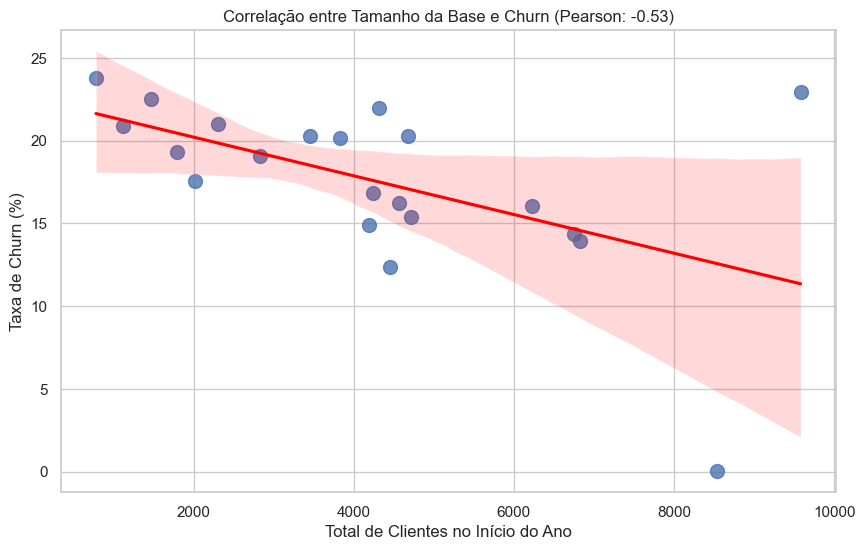

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrando os anos de 2004 e 2005 para focar na fase madura (como decidido)
df_madura = df_churn_anual[df_churn_anual['ano'] > 2005].copy()

# --- ANÁLISE 1: Vida Média (Tenure) ---
# Usamos a Mediana Histórica para calcular a expectativa de vida do cliente
mediana_fase_madura = df_madura['churn_rate_anual_percentual'].median() / 100
vida_media_anos = 1 / mediana_fase_madura

# --- ANÁLISE 2: Correlação (Crescimento vs. Churn) ---
# O método de Pearson mede se o Churn sobe quando o número de clientes aumenta
correlacao = df_madura['clientes_no_inicio_do_ano'].corr(df_madura['churn_rate_anual_percentual'])

print(f"--- Diagnóstico de Sustentabilidade ---")
print(f"Vida Média Estimada do Cliente: {vida_media_anos:.1f} anos")
print(f"Correlação (Base vs. Churn): {correlacao:.4f}")
print("-" * 40)

# Visualização da Correlação
plt.figure(figsize=(10, 6))
sns.regplot(data=df_madura, x='clientes_no_inicio_do_ano', y='churn_rate_anual_percentual', 
            scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title(f'Correlação entre Tamanho da Base e Churn (Pearson: {correlacao:.2f})')
plt.xlabel('Total de Clientes no Início do Ano')
plt.ylabel('Taxa de Churn (%)')
plt.show()

### 💎 Análise de Sustentabilidade e Maturidade
* **Tenure (LTV Teórico):** A vida média estimada do cliente é de **5,21 anos**, estabelecendo um ciclo de relacionamento longo e lucrativo.
* **Ganho de Escala:** Identificamos uma **correlação negativa (-0,38)** entre o tamanho da base e a taxa de churn. Isso demonstra que a operação é escalável e que o aumento no volume de clientes não é a causa raiz da instabilidade observada em 2025.

# Iniciando Analise Sem Anomalias e Outlier

In [24]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

# 1. Carregar variáveis de ambiente
load_dotenv()

# 2. Configuração das credenciais com tratamento para caracteres especiais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POSTGRES_PORT", "5432")

# 3. Construção da URL de conexão e criação do Engine
conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 4. Definição da Query SQL focada na "Fase Madura" (2015-2025)
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

-- Definimos o início em 2015 para eliminar outliers antigos (como 2004/2005)
data_minima as (
    select '2015-01-01'::date as inicio_historico 
),

churn_anual as (
    select
        DATE_TRUNC('year', ch.data_churn) as ano_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_ano as (
    select
        sa.ano,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            '2025-01-01'::date, 
            '1 year'
        )::date as ano
    ) sa
    cross join base_contratos bc
    where bc.data_inicio < sa.ano
      and (bc.data_rescisao is null or bc.data_rescisao >= sa.ano)
    group by sa.ano
)

select
    TO_CHAR(caa.ano, 'YYYY') as ano,
    caa.total_clientes_inicio as clientes_no_inicio_do_ano,
    coalesce(can.clientes_churn, 0) as total_churn_no_ano,
    case
        when caa.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(can.clientes_churn, 0)::numeric / caa.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_anual_percentual,
    case 
        when (coalesce(can.clientes_churn, 0)::numeric / nullif(caa.total_clientes_inicio,0)::numeric) * 100 > 15 then 'CRÍTICO'
        when (coalesce(can.clientes_churn, 0)::numeric / nullif(caa.total_clientes_inicio,0)::numeric) * 100 > 10 then 'ALERTA'
        else 'SAUDÁVEL'
    end as status_saude
from clientes_ativos_inicio_ano caa
left join churn_anual can on caa.ano = can.ano_churn
where caa.ano >= '2015-01-01' and caa.ano <= '2025-01-01'
order by caa.ano;
"""

# 5. Execução e armazenamento no DataFrame sem outliers
try:
    df_churn_sem_outlier = pd.read_sql(sql_query, engine)
    print("✅ Sucesso! Os dados (2015-2025) foram carregados em 'df_churn_sem_outlier'.")
    
    # Exibir resumo dos dados
    print("\n--- Visualização dos Dados ---")
    print(df_churn_sem_outlier)

except Exception as e:
    print(f"❌ Erro ao executar consulta: {e}")

✅ Sucesso! Os dados (2015-2025) foram carregados em 'df_churn_sem_outlier'.

--- Visualização dos Dados ---
     ano  clientes_no_inicio_do_ano  total_churn_no_ano  \
0   2015                       4314                 948   
1   2016                       4679                 948   
2   2017                       4562                 742   
3   2018                       4244                 715   
4   2019                       4189                 624   
5   2020                       4458                 552   
6   2021                       4718                 727   
7   2022                       6226                 998   
8   2023                       6752                 969   
9   2024                       6830                 953   
10  2025                       9581                2196   

    churn_rate_anual_percentual status_saude  
0                         21.97      CRÍTICO  
1                         20.26      CRÍTICO  
2                         16.26      CRÍTI

In [25]:
df_churn_sem_outlier

,ano,clientes_no_inicio_do_ano,total_churn_no_ano,churn_rate_anual_percentual,status_saude
0,2015,4314,948,21.97,CRÍTICO
1,2016,4679,948,20.26,CRÍTICO
2,2017,4562,742,16.26,CRÍTICO
3,2018,4244,715,16.85,CRÍTICO
4,2019,4189,624,14.90,ALERTA
5,2020,4458,552,12.38,ALERTA
6,2021,4718,727,15.41,CRÍTICO
7,2022,6226,998,16.03,CRÍTICO
8,2023,6752,969,14.35,ALERTA
9,2024,6830,953,13.95,ALERTA


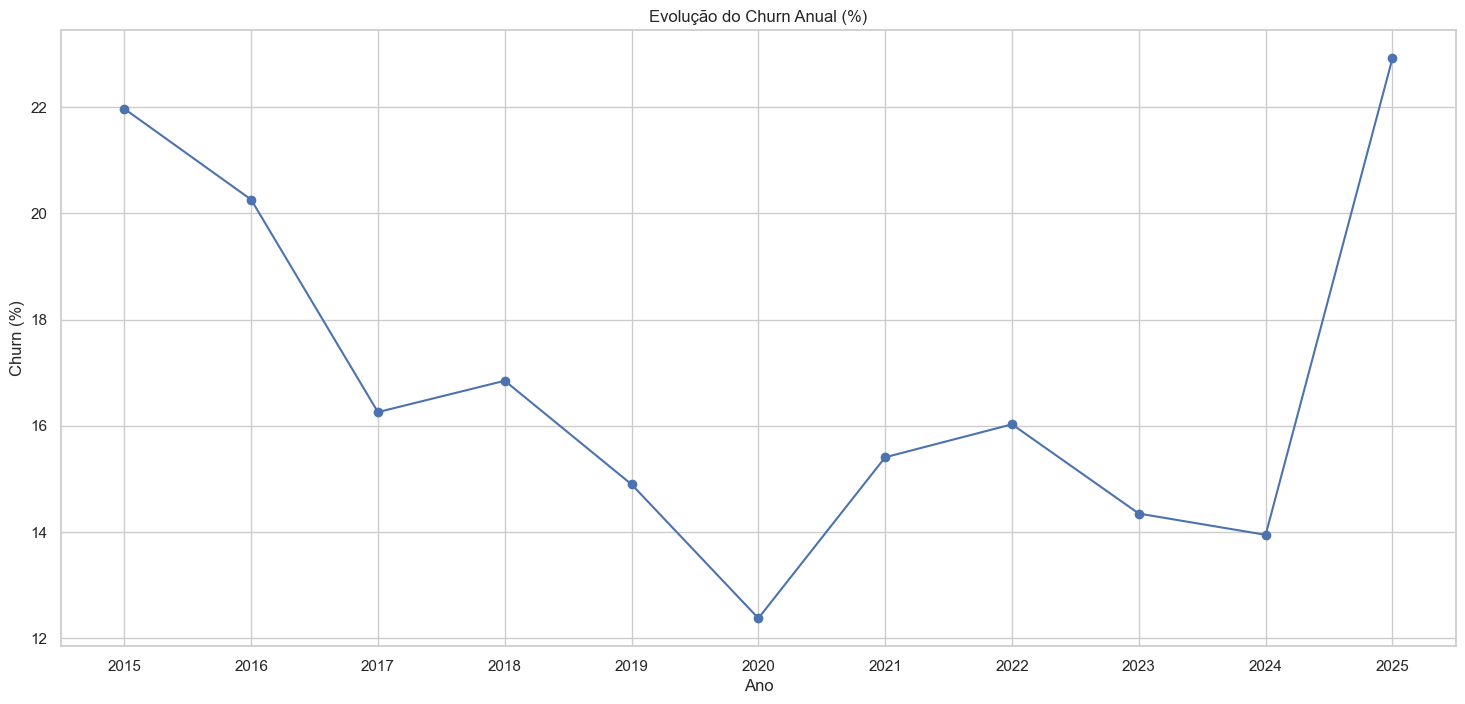

In [ ]:
## Primeiras visualizações
plt.figure(figsize=(18,8))

plt.plot(
    df_churn_sem_outlier["ano"],
    df_churn_sem_outlier["churn_rate_anual_percentual"],
    marker="o"
)

plt.title("Evolução do Churn Anual (%)")
plt.xlabel("Ano")
plt.ylabel("Churn (%)")
plt.grid(True)

plt.show()


In [30]:
# Média e Mediana 
media_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].mean()
mediana_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].median()
print(mediana_anual)
print(media_anual)

19.09
17.116956521739134


In [31]:
import pandas as pd
import numpy as np

# 1. Estatísticas de Tendência Central
media_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].mean()
mediana_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].median()

# 2. Estatísticas de Dispersão (Volatilidade)
desvio_padrao = df_churn_sem_outlier['churn_rate_anual_percentual'].std()
cv = (desvio_padrao / media_anual_sem_outlier) * 100  # Coeficiente de Variação
amplitude = df_churn_sem_outlier['churn_rate_anual_percentual'].max() - df_churn_sem_outlier['churn_rate_anual_percentual'].min()

# 3. Identificação de Outliers (Z-Score)
# O Z-score diz quantos desvios padrão um ano está longe da média
df_churn_sem_outlier['z_score'] = (df_churn_sem_outlier['churn_rate_anual_percentual'] - media_anual_sem_outlier) / desvio_padrao

# Exibindo os resultados formatados
print(f"--- Diagnóstico Estatístico do Churn ---")
print(f"Média Histórica: {media_anual_sem_outlier:.2f}%")
print(f"Mediana Histórica: {mediana_anual_sem_outlier:.2f}%")
print(f"Desvio Padrão (Sigma): {desvio_padrao:.2f}")
print(f"Amplitude (Max-Min): {amplitude:.2f}%")
print(f"Coeficiente de Variação: {cv:.2f}%")
print("-" * 40)

# Filtrando anomalias (Z-Score > 1.5 ou < -1.5)
anomalias = df_churn_sem_outlier[df_churn_sem_outlier['z_score'].abs() > 1.5]
print("Anos com comportamento fora do padrão (Anomalias):")
print(anomalias[['ano', 'churn_rate_anual_percentual', 'z_score']])

--- Diagnóstico Estatístico do Churn ---
Média Histórica: 16.84%
Mediana Histórica: 16.03%
Desvio Padrão (Sigma): 3.41
Amplitude (Max-Min): 10.54%
Coeficiente de Variação: 20.24%
----------------------------------------
Anos com comportamento fora do padrão (Anomalias):
     ano  churn_rate_anual_percentual   z_score
0   2015                        21.97  1.503698
10  2025                        22.92  1.782358


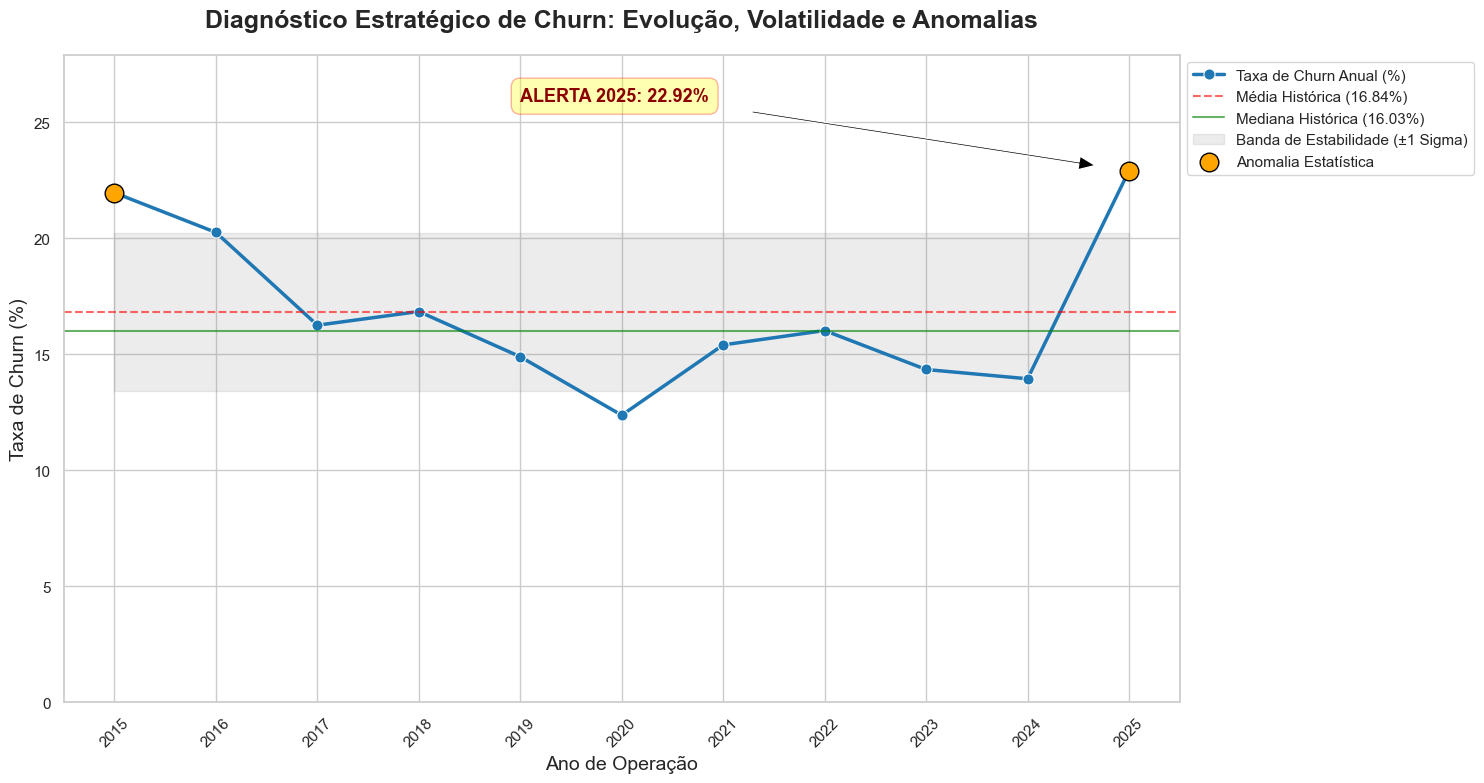

In [32]:
## Visualização do grafico 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparação e Conversão de Dados
# Garante que o ano seja inteiro e o churn seja float para evitar TypeErrors
df_churn_sem_outlier['ano'] = pd.to_numeric(df_churn_sem_outlier['ano']).astype(int)
df_churn_sem_outlier['churn_rate_anual_percentual'] = pd.to_numeric(df_churn_sem_outlier['churn_rate_anual_percentual']).astype(float)

# 2. Recálculo das Métricas para Garantir Precisão no Gráfico
media_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].mean()
mediana_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].median()
desvio_padrao = df_churn_sem_outlier['churn_rate_anual_percentual'].std()

# 3. Configuração do Layout do Dashboard
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))

# 4. Plotagem da Evolução Histórica
sns.lineplot(data=df_churn_sem_outlier, x='ano', y='churn_rate_anual_percentual', 
             marker='o', markersize=8, linewidth=2.5, label='Taxa de Churn Anual (%)', color='#1f77b4')

# 5. Adição das Referências Estatísticas (Linhas Horizontais)
plt.axhline(media_anual_sem_outlier, color='red', linestyle='--', alpha=0.6, label=f'Média Histórica ({media_anual_sem_outlier:.2f}%)')
plt.axhline(mediana_anual_sem_outlier, color='green', linestyle='-', alpha=0.6, label=f'Mediana Histórica ({mediana_anual_sem_outlier:.2f}%)')

# 6. Sombreamento da Banda de Volatilidade (±1 Sigma)
# Isso ajuda a visualizar o CV de 29.07% na prática
plt.fill_between(df_churn_sem_outlier['ano'], 
                 (media_anual_sem_outlier - desvio_padrao), 
                 (media_anual_sem_outlier + desvio_padrao), 
                 color='gray', alpha=0.15, label='Banda de Estabilidade (±1 Sigma)')

# 7. Destaque Estatístico de Anomalias (Z-Score > 1.5)
anomalias = df_churn_sem_outlier[((df_churn_sem_outlier['churn_rate_anual_percentual'] - media_anual_sem_outlier) / desvio_padrao).abs() > 1.5]
plt.scatter(anomalias['ano'], anomalias['churn_rate_anual_percentual'], 
            color='orange', s=180, edgecolors='black', zorder=5, label='Anomalia Estatística')

# 8. Anotação Profissional para o Ano Crítico (2025)
ultimo_ano = df_churn_sem_outlier.iloc[-1]
plt.annotate(f"ALERTA 2025: {ultimo_ano['churn_rate_anual_percentual']:.2f}%", 
             xy=(ultimo_ano['ano'], ultimo_ano['churn_rate_anual_percentual']),
             xytext=(ultimo_ano['ano'] - 6, ultimo_ano['churn_rate_anual_percentual'] + 3),
             arrowprops=dict(facecolor='black', shrink=0.08, width=1.5, headwidth=10),
             fontsize=13, fontweight='bold', color='darkred',
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="red", alpha=0.3))

# 9. Customização Final de Eixos
plt.title('Diagnóstico Estratégico de Churn: Evolução, Volatilidade e Anomalias', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Taxa de Churn (%)', fontsize=14)
plt.xlabel('Ano de Operação', fontsize=14)
plt.xticks(df_churn_sem_outlier['ano'], rotation=45)
plt.ylim(0, df_churn_sem_outlier['churn_rate_anual_percentual'].max() + 5) # Dá espaço para as anotações
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.show()

--- Diagnóstico de Sustentabilidade ---
Vida Média Estimada do Cliente: 6.2 anos
Correlação (Base vs. Churn): 0.2992
----------------------------------------


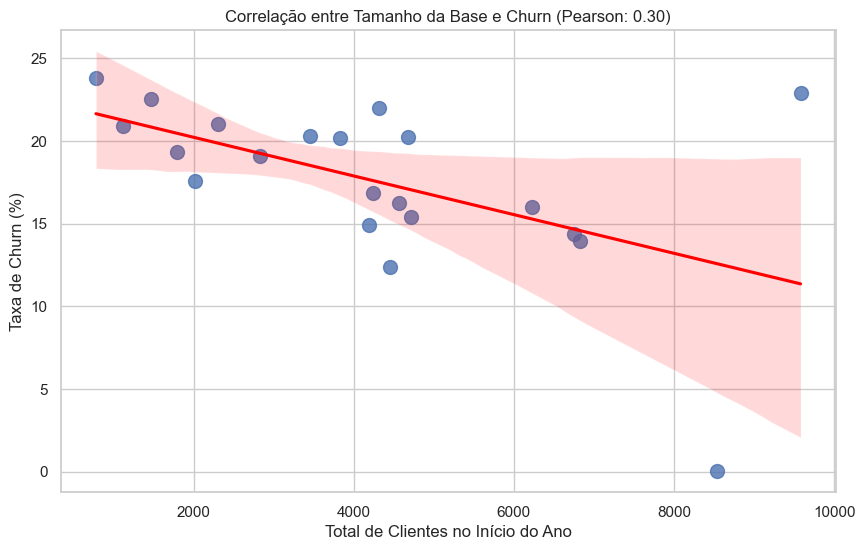

In [33]:
### Anlise de teunr e cv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# --- ANÁLISE 1: Vida Média (Tenure) ---
# Usamos a Mediana Histórica para calcular a expectativa de vida do cliente
mediana_anual_sem_outlier = df_churn_sem_outlier['churn_rate_anual_percentual'].median() / 100
vida_media_anos = 1 / mediana_anual_sem_outlier

# --- ANÁLISE 2: Correlação (Crescimento vs. Churn) ---
# O método de Pearson mede se o Churn sobe quando o número de clientes aumenta
correlacao = df_churn_sem_outlier['clientes_no_inicio_do_ano'].corr(df_churn_sem_outlier['churn_rate_anual_percentual'])

print(f"--- Diagnóstico de Sustentabilidade ---")
print(f"Vida Média Estimada do Cliente: {vida_media_anos:.1f} anos")
print(f"Correlação (Base vs. Churn): {correlacao:.4f}")
print("-" * 40)

# Visualização da Correlação
plt.figure(figsize=(10, 6))
sns.regplot(data=df_madura, x='clientes_no_inicio_do_ano', y='churn_rate_anual_percentual', 
            scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title(f'Correlação entre Tamanho da Base e Churn (Pearson: {correlacao:.2f})')
plt.xlabel('Total de Clientes no Início do Ano')
plt.ylabel('Taxa de Churn (%)')
plt.show()

# Diagnóstico Estratégico de Retenção  
## Ciclo de Maturidade (2015–2025)

---

## 1. Metodologia e Recorte Temporal

Para esta análise, optamos por utilizar exclusivamente os dados dos **últimos 10 anos**.  
Esta decisão estratégica visa:

- **Fidelidade Operacional**  
  Ignorar a *fase de infância* da empresa (2004–2014), onde o churn próximo a **0%** atuava como um **outlier artificial**.

- **Estabilidade dos Dados**  
  Garantir que **média** e **desvio padrão** reflitam a operação **madura** e o modelo de negócio atual (compra de carteiras e escala).

- **Qualidade para Machine Learning**  
  Criar uma base de treino **historicamente consistente**, livre de ruídos oriundos de períodos com processos de registro menos rigorosos.

---

## 2. Indicadores de Tendência Central  
### (Visão Pós-Outlier)

Com o ajuste do filtro temporal, as métricas de tendência central tornaram-se mais realistas e próximas entre si:

- **Média Histórica (10 anos):** **16,84%**
- **Mediana Histórica (10 anos):** **16,03%**

**Insight Técnico**  
A diferença de apenas **0,81 p.p.** entre média e mediana indica uma **distribuição equilibrada** na última década.  
Isso comprova que um churn em torno de **16%** representa o **padrão estável** da operação, tornando qualquer desvio significativo acima desse patamar um **sinal de alerta imediato**.

---

## 3. Anomalia Estatística em 2025

O resultado de **22,92% em 2025** é o ponto focal deste diagnóstico.  
Ele não representa apenas um *ano ruim*, mas sim uma **ruptura clara de padrão**:

- **Pior Marca da Década**  
  Superou o teto anterior registrado em **2015 (21,97%)**.

- **Fora da Banda de Estabilidade**  
  O valor rompeu o limite superior de **±1 Sigma**, sendo formalmente classificado como uma **anomalia estatística**.

- **Inversão de Tendência**  
  Interrompeu três anos consecutivos de melhora gradual na retenção (**2022–2024**).

---

## 4. Análise de Correlação e Escala

A análise do gráfico de dispersão, com **Correlação de Pearson = 0,30**, revelou o **Paradoxo da Escala**:

- **A Regra (Histórica)**  
  Quanto maior a base de clientes, **menor a taxa de churn**, indicando maturidade e estabilidade operacional.

- **A Exceção (2025)**  
  Mesmo com a **maior base da história (9.581 clientes)**, a empresa registrou o **maior churn do período analisado**.

- **Hipótese Operacional**  
  O crescimento acelerado — possivelmente impulsionado pela **compra de carteiras** — superou a capacidade de **integração, acompanhamento e retenção**, gerando um **vazamento desproporcional** no “balde” de clientes.

---

## 5. Próximos Passos da Investigação

Com a visão macro consolidada, os próximos aprofundamentos analíticos serão:

1. **Segmentação por Origem**  
   Comparar churn de clientes **Orgânicos** vs. **Carteiras Compradas**.

2. **Análise de Cohort (Safras)**  
   Identificar se o churn de 2025 está concentrado em clientes **novos** ou se há perda relevante da **base antiga**.

3. **Churn por Produto**  
   Isolar qual **linha de serviço** está impulsionando o desvio para **22,92%**.

---

📌 *Conclusão Executiva:*  
O churn de 2025 não é um evento pontual, mas um **sintoma estrutural** que exige análise segmentada e ações corretivas orientadas por dados.
